# Week 5: GANs

In [47]:
import os
from typing import Dict, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pywt
import seaborn as sns
import tensorflow as tf
from scipy.stats import skew
from skimage import color, img_as_ubyte
from skimage.feature import graycomatrix, graycoprops
from tabulate import tabulate
from tqdm import tqdm

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.mixed_precision import experimental as mixed_precision
from tensorflow.keras.models import Model
import tensorflow_addons as tfa


In [65]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
print(tf.__version__)


2.10.0


### The Challenge:

A GAN consists of at least two neural networks: a generator model and a discriminator model. The generator is a neural network that creates the images. For our competition, you should generate images in the style of Monet. This generator is trained using a discriminator.

The two models will work against each other, with the generator trying to trick the discriminator, and the discriminator trying to accurately classify the real vs. generated images.

Your task is to build a GAN that generates 7,000 to 10,000 Monet-style images.

In [3]:
def decode_image(image: tf.Tensor) -> tf.Tensor:
    
    """
    Decode a JPEG-encoded image to a 3D float tensor, normalize it, and reshape it 
    to a predefined size.
    """
    
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.image.resize(image, IMAGE_SIZE)  # Add resizing here
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    
    return image



def read_tfrecord(example: tf.Tensor) -> tf.Tensor:
    
    """
    Parse a single example from a TFRecord, decode the image contained within, 
    and return the processed image tensor.
    """
    
    tfrecord_format: Dict[str, tf.io.FixedLenFeature] = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
        
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    
    return image

def load_dataset(filenames: List[str], labeled: bool = True, ordered: bool = False) -> tf.data.Dataset:
    
    """
    Load a dataset from a list of TFRecord filenames, and map the data to the corresponding processing function.
    """
    
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    
    return dataset

In [4]:
local_path = "/Users/flaviab/Downloads/gan-getting-started/"
IMAGE_SIZE = [256, 256]

monet_filenames = [os.path.join(local_path, 'monet_tfrec', f) for f in os.listdir(os.path.join(local_path, 'monet_tfrec')) if f.endswith('.tfrec')]
photo_filenames = [os.path.join(local_path, 'photo_tfrec', f) for f in os.listdir(os.path.join(local_path, 'photo_tfrec')) if f.endswith('.tfrec')]

monet_dataset = load_dataset(monet_filenames, labeled=True).batch(32, drop_remainder=True)
photo_dataset = load_dataset(photo_filenames, labeled=True).batch(32, drop_remainder=True)

# EDA: Data Exploratory Analysis 

#### EDA PLAN

This EDA strategy lets us dive deep into Monet's style versus regular photos. Grasping these variances is key for better understanding of the data and getting insights.

- Getting to Know Monet's Style: We're aiming to figure out what makes Monet's paintings distinct from typical photographs;

- Laying the Groundwork: By understanding these nuances, we'll be better prepared for transferring Monet's style to a photo or distinguishing between different types of images;

- Visual Comparisons: These tools give us both a visual and a numbers-driven look into the two image types. This helps us pinpoint exactly what sets Monet's style apart;


In [49]:
def display_images(dataset, n=10) -> None:
    
    """
    Display n sample images from the given dataset.
    """
    
    plt.figure(figsize=(15, 5))
    for i, image in enumerate(dataset.take(n)):
        plt.subplot(1, n, i+1)
        plt.imshow(image[0] * 0.5 + 0.5)  # Unnormalize the image
        plt.axis('off')
    plt.show()

    
def extract_pixel_values(dataset, n=1000) -> np.array:
    
    """
    Extract pixel values from n images in the given dataset.
    """
    
    pixel_values = np.array([], dtype=np.float32)
    
    for image in dataset.take(n):
        pixel_values = np.append(pixel_values, image.numpy())
    
    return pixel_values


def plot_histograms(monet_dataset, photo_dataset, n=1000) -> None:
    
    """
    Plot histograms of pixel intensity values of n images for both datasets side by side.
    """
    
    monet_pixels = extract_pixel_values(monet_dataset, n)
    photo_pixels = extract_pixel_values(photo_dataset, n)
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    axes[0].hist(monet_pixels, bins=50, color='navy')
    axes[0].set_title("Monet Paintings Pixel Intensities")
    axes[0].set_xlabel("Pixel Intensity")
    axes[0].set_ylabel("Frequency")
    
    axes[1].hist(photo_pixels, bins=50, color='green')
    axes[1].set_title("Photos Pixel Intensities")
    axes[1].set_xlabel("Pixel Intensity")
    axes[1].set_ylabel("Frequency")
    
    plt.tight_layout()
    plt.show()    
    
    
def compute_statistics(dataset, n=1000) -> Tuple[float, float]:
    
    """
    Compute mean and standard deviation of pixel intensity values of n images from the given dataset.
    """

    pixel_values = extract_pixel_values(dataset, n)
    
    return np.mean(pixel_values), np.std(pixel_values)
    

def color_distributions(dataset1: tf.data.Dataset, dataset2: tf.data.Dataset, labels: List[str], n: int = 1000) -> Tuple[Tuple[np.array, np.array, np.array], Tuple[np.array, np.array, np.array]]:
    
    """
    Calculate and visualize the color distributions for Red, Green, and Blue channels 
    for a subset of images from the given datasets.
    """
    
    datasets = [dataset1, dataset2]
    
    for i, dataset in enumerate(datasets):
        red_values, green_values, blue_values = np.array([], dtype=np.float32), np.array([], dtype=np.float32), np.array([], dtype=np.float32)
        
        for image in dataset.take(n):
            
            img_np = ((image.numpy() + 1) * 127.5).astype(np.uint8)
            red_values = np.append(red_values, img_np[..., 0])
            green_values = np.append(green_values, img_np[..., 1])
            blue_values = np.append(blue_values, img_np[..., 2])
        
        fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
        
        axes[0].hist(red_values, bins=50, color='red', alpha=0.7)
        axes[0].set_title(f"Red Channel Distribution ({labels[i]})")
        axes[0].set_xlabel("Pixel Intensity")
        axes[0].set_ylabel("Frequency")
        
        axes[1].hist(green_values, bins=50, color='green', alpha=0.7)
        axes[1].set_title(f"Green Channel Distribution ({labels[i]})")
        axes[1].set_xlabel("Pixel Intensity")
        
        axes[2].hist(blue_values, bins=50, color='blue', alpha=0.7)
        axes[2].set_title(f"Blue Channel Distribution ({labels[i]})")
        axes[2].set_xlabel("Pixel Intensity")
        
        plt.tight_layout()
        plt.show()
    
    return (red_values, green_values, blue_values)

def glcm_analysis(image: np.ndarray) -> (np.ndarray, np.ndarray, np.ndarray):
    
    """
    Analyzes the image using the Gray Level Co-occurrence Matrix (GLCM).
    Returns contrast, dissimilarity, and homogeneity features.
    """
    
    grayscale = img_as_ubyte(rgb2gray(image))
    glcm = graycomatrix(grayscale, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0]
    dissimilarity = graycoprops(glcm, 'dissimilarity')[0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0]
    
    return contrast, dissimilarity, homogeneity

def wavelet_decomposition(image: np.ndarray) -> (np.ndarray, np.ndarray, np.ndarray, np.ndarray):
    
    """
    Decomposes the image using wavelet transformation.
    Returns approximation and details in horizontal, vertical and diagonal directions.
    """
    
    grayscale = rgb2gray(image)
    coeffs = pywt.dwt2(grayscale, 'db1')
    cA, (cH, cV, cD) = coeffs
    
    return cA, cH, cV, cD


def visualize_glcm_from_ds(image: np.ndarray) -> None:
    
    """
    Visualizes the GLCM of an image from the dataset.
    """
    
    grayscale = img_as_ubyte(color.rgb2gray(image))
    glcm = graycomatrix(grayscale, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], 
                        symmetric=True, normed=True)
    plt.imshow(glcm[:, :, 0, 0], cmap='gray')
    plt.colorbar()
    plt.title("GLCM of the image")
    plt.show()


def visualize_wavelet_from_ds(image: np.ndarray) -> None:
    
    """
    Visualizes the wavelet decomposition of an image from the dataset.
    """
    
    grayscale = color.rgb2gray(image)
    coeffs = pywt.dwt2(grayscale, 'db1')
    cA, (cH, cV, cD) = coeffs
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    axes[0].imshow(cA, cmap='gray')
    axes[0].set_title('Approximation Coefficients (cA)')
    axes[1].imshow(cH, cmap='gray')
    axes[1].set_title('Horizontal Detail (cH)')
    axes[2].imshow(cV, cmap='gray')
    axes[2].set_title('Vertical Detail (cV)')
    axes[3].imshow(cD, cmap='gray')
    axes[3].set_title('Diagonal Detail (cD)')
    for ax in axes:
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
    
def visualize_glcm_side_by_side(monet_image: np.ndarray, photo_image: np.ndarray) -> None:
    
    """
    Visualize the Gray-Level Co-occurrence Matrix (GLCM) for given Monet and photo images side by side.
    """
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    for ax, image, title in zip(axes, 
                                [monet_image, photo_image], 
                                ["Monet Image GLCM", "Photo Image GLCM"]):
        
        grayscale = img_as_ubyte(color.rgb2gray(image))
        glcm = graycomatrix(grayscale, [1], [0], symmetric=True, normed=True)
        
        cax = ax.imshow(glcm[:, :, 0, 0], cmap='gray')
        ax.set_title(title)
        ax.axis('off')
        
        fig.colorbar(cax, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.show()

    
def wavelet_features_from_ds(image: np.ndarray) -> (float, float):
    
    """
    Extracts wavelet-based features (energy and standard deviation) from an image in the dataset.
    """
    
    grayscale = color.rgb2gray(image)
    coeffs = pywt.dwt2(grayscale, 'db1')
    cA, (cH, cV, cD) = coeffs
    energy = np.sum(cA**2) + np.sum(cH**2) + np.sum(cV**2) + np.sum(cD**2)
    std = np.std(np.concatenate([cA.ravel(), cH.ravel(), cV.ravel(), cD.ravel()]))
    
    return energy, std


def extract_features(image: np.array, layer_names: List[str]) -> List[np.array]:
    
    """
    Extract features from specified layers of a pre-trained VGG16 model.
    """
    
    base_model = VGG16(weights='imagenet', include_top=False)
    
    layers = [base_model.get_layer(name).output for name in layer_names]
    model = Model(inputs=base_model.input, outputs=layers)
    
    processed_image = tf.keras.applications.vgg16.preprocess_input(image)
    activations = model.predict(processed_image)
    
    return activations


def image_statistics(image: np.array) -> Dict[str, float]:
    
    """
    Compute basic statistical properties of an image.
    """
    
    if isinstance(image, tf.Tensor):
        image = image.numpy()

    stats = {
        'Red Mean': np.mean(image[..., 0]),
        'Red Median': np.median(image[..., 0]),
        'Red Std': np.std(image[..., 0]),
        'Red Skewness': skew(image[..., 0].flatten()),

        'Green Mean': np.mean(image[..., 1]),
        'Green Median': np.median(image[..., 1]),
        'Green Std': np.std(image[..., 1]),
        'Green Skewness': skew(image[..., 1].flatten()),

        'Blue Mean': np.mean(image[..., 2]),
        'Blue Median': np.median(image[..., 2]),
        'Blue Std': np.std(image[..., 2]),
        'Blue Skewness': skew(image[..., 2].flatten())
    }

    return stats


def channel_correlation(image: np.array) -> Dict[str, float]:
    
    """
    Calculate correlation coefficients between color channels of an image.
    """
    
    red = image[..., 0].flatten()
    green = image[..., 1].flatten()
    blue = image[..., 2].flatten()
    
    correlations = {
        'Red-Green Correlation': np.corrcoef(red, green)[0, 1],
        'Red-Blue Correlation': np.corrcoef(red, blue)[0, 1],
        'Green-Blue Correlation': np.corrcoef(green, blue)[0, 1]
    }
    
    return correlations


def compute_sharpness(image: np.array) -> float:
    
    """
    Compute the sharpness of an image based on the variance of its Laplacian.
    """
    
    grayscale = rgb2gray(image)
    
    return laplace(grayscale).var()


def plot_boxplots_together(red_data: np.ndarray, green_data: np.ndarray, blue_data: np.ndarray, title: str) -> None:
    
    """
    Plots boxplots for the given red, green, and blue data arrays together with specified title.
    """
    
    plt.figure(figsize=(15, 6))
    
    plt.boxplot(red_data, positions=[1], patch_artist=True, 
                boxprops=dict(facecolor="red"), capprops=dict(color="red"), 
                whiskerprops=dict(color="red"), flierprops=dict(color="red", markeredgecolor="red"), 
                medianprops=dict(color="darkred"))

    plt.boxplot(green_data, positions=[2], patch_artist=True, 
                boxprops=dict(facecolor="green"), capprops=dict(color="green"), 
                whiskerprops=dict(color="green"), flierprops=dict(color="green", markeredgecolor="green"), 
                medianprops=dict(color="darkgreen"))
    
    plt.boxplot(blue_data, positions=[3], patch_artist=True, 
                boxprops=dict(facecolor="blue"), capprops=dict(color="blue"), 
                whiskerprops=dict(color="blue"), flierprops=dict(color="blue", markeredgecolor="blue"), 
                medianprops=dict(color="darkblue"))
    
    plt.title(title)
    plt.xticks([1, 2, 3], ["Red", "Green", "Blue"])
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

    


Sample Monet Paintings:


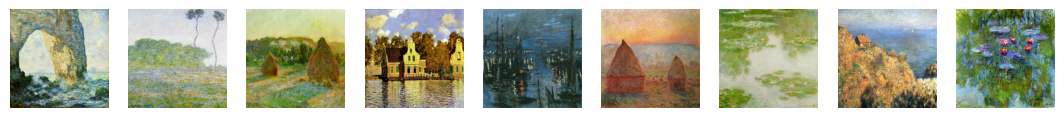


Sample Photos:


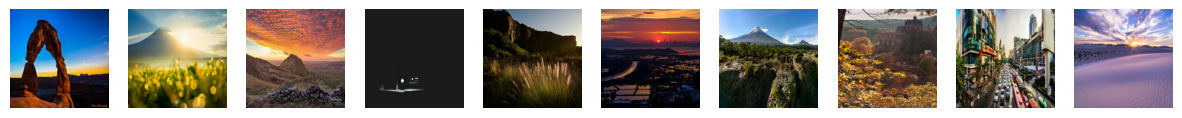

CPU times: user 2.69 s, sys: 1.91 s, total: 4.6 s
Wall time: 5.13 s


In [50]:
%%time

print("Sample Monet Paintings:")
display_images(monet_dataset)

print("\nSample Photos:")
display_images(photo_dataset)

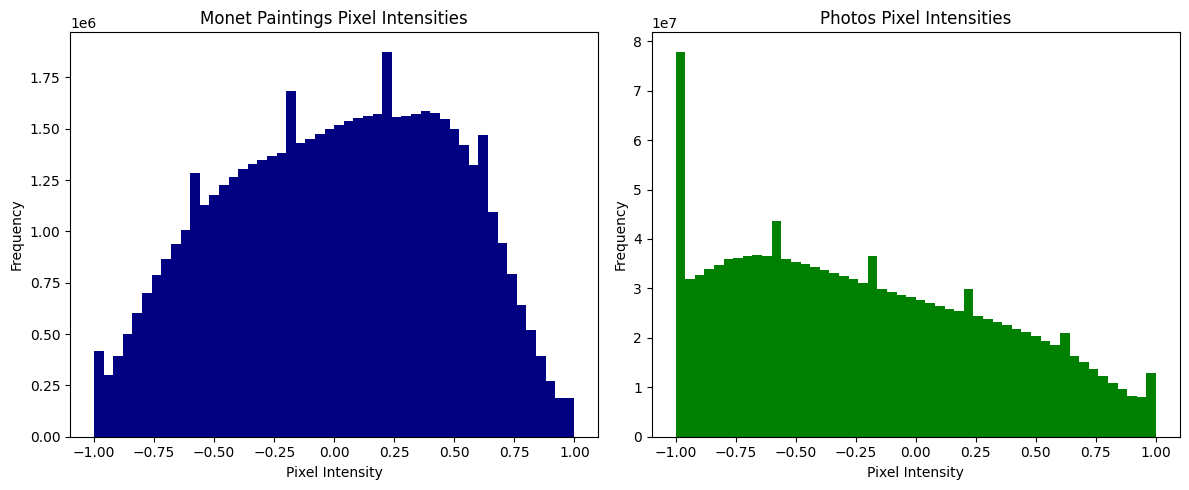

CPU times: user 4min 16s, sys: 5min 46s, total: 10min 2s
Wall time: 12min 1s


In [51]:
%%time

plot_histograms(monet_dataset, photo_dataset)

In [52]:
%%time

monet_mean, monet_std = compute_statistics(monet_dataset, n=1000)
photo_mean, photo_std = compute_statistics(photo_dataset, n=1000)

print(f"Monet Paintings: Mean Pixel Intensity = {monet_mean:.2f}, Stddev = {monet_std:.2f}")
print(f"Photos: Mean Pixel Intensity = {photo_mean:.2f}, Stddev = {photo_std:.2f}")


Monet Paintings: Mean Pixel Intensity = 0.01, Stddev = 0.47
Photos: Mean Pixel Intensity = -0.20, Stddev = 0.53
CPU times: user 4min 10s, sys: 8min 25s, total: 12min 35s
Wall time: 16min 46s


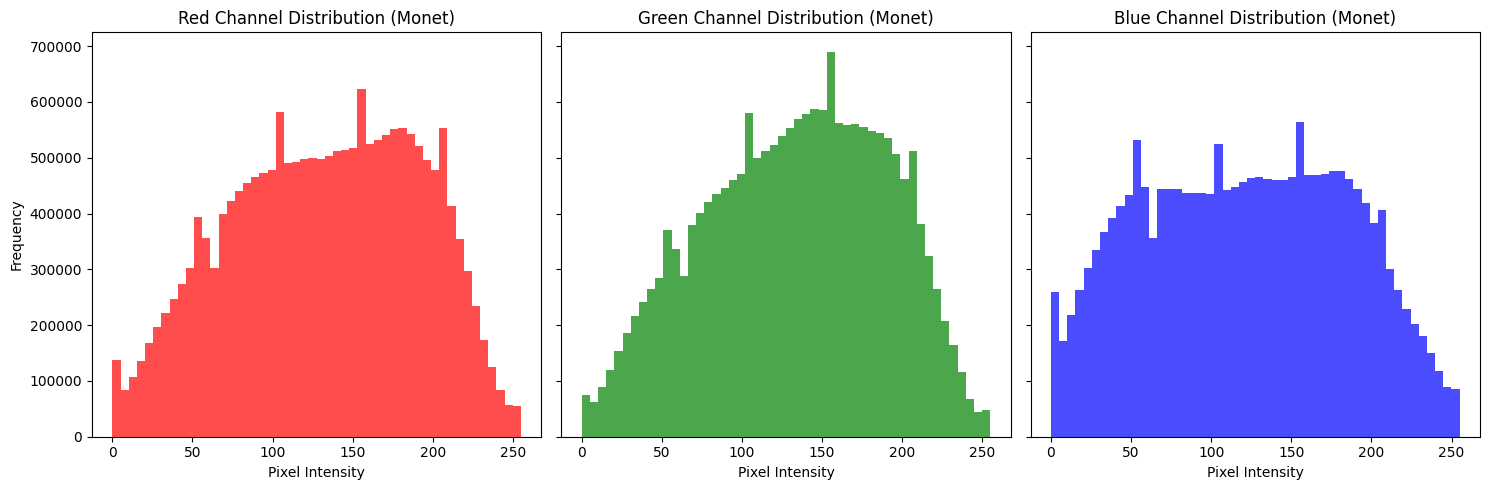

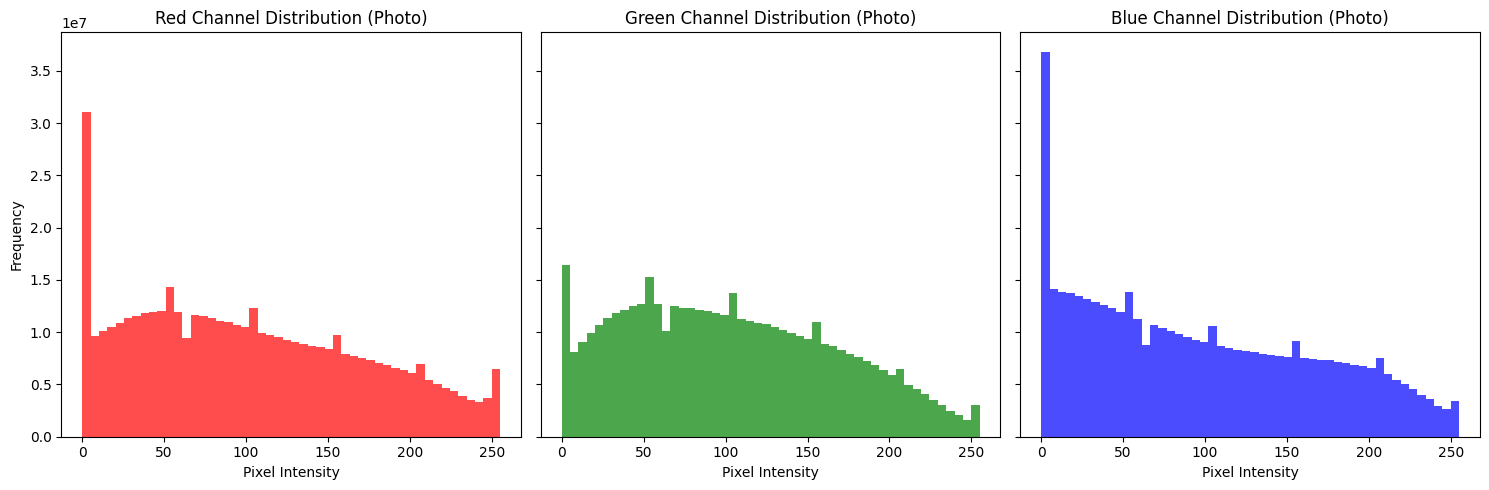

CPU times: user 4min 2s, sys: 3min 11s, total: 7min 13s
Wall time: 7min 10s


(array([  0.,   0.,   0., ..., 137., 145., 152.], dtype=float32),
 array([45., 53., 61., ..., 90., 93., 99.], dtype=float32),
 array([141., 155., 170., ...,  47.,  45.,  48.], dtype=float32))

In [53]:
%%time

color_distributions(monet_dataset, photo_dataset, ["Monet", "Photo"])

In [54]:
warnings.filterwarnings("ignore", category=UserWarning)

monet_image = next(iter(monet_dataset)).numpy()[0]
photo_image = next(iter(photo_dataset)).numpy()[0]
monet_glcm_features = glcm_analysis(monet_image)
photo_glcm_features = glcm_analysis(photo_image)

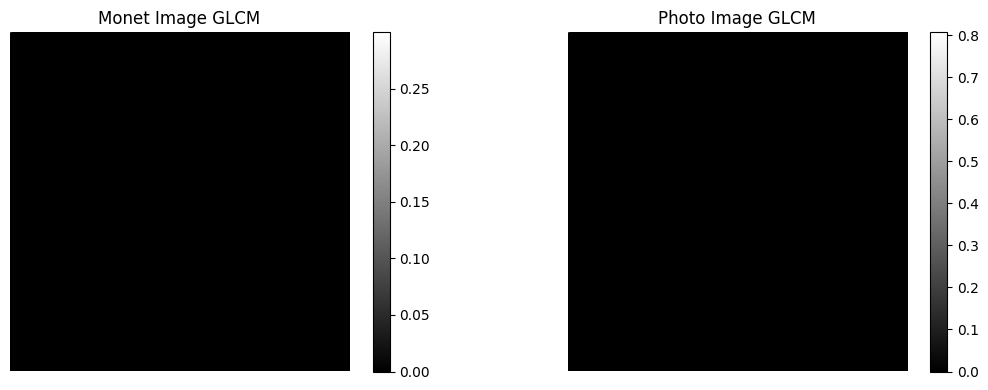

CPU times: user 398 ms, sys: 59.4 ms, total: 457 ms
Wall time: 539 ms


In [55]:
%%time

warnings.filterwarnings("ignore", category=UserWarning)

visualize_glcm_side_by_side(monet_image, photo_image)

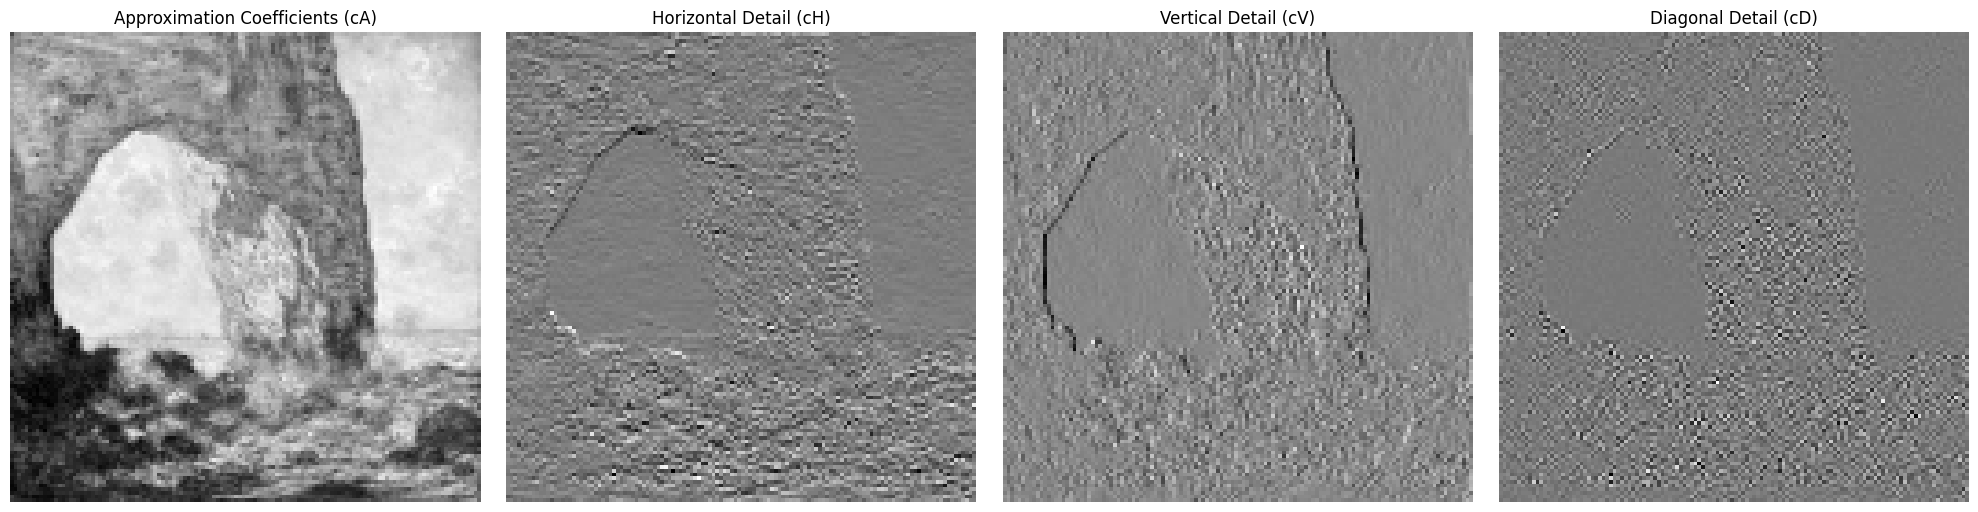

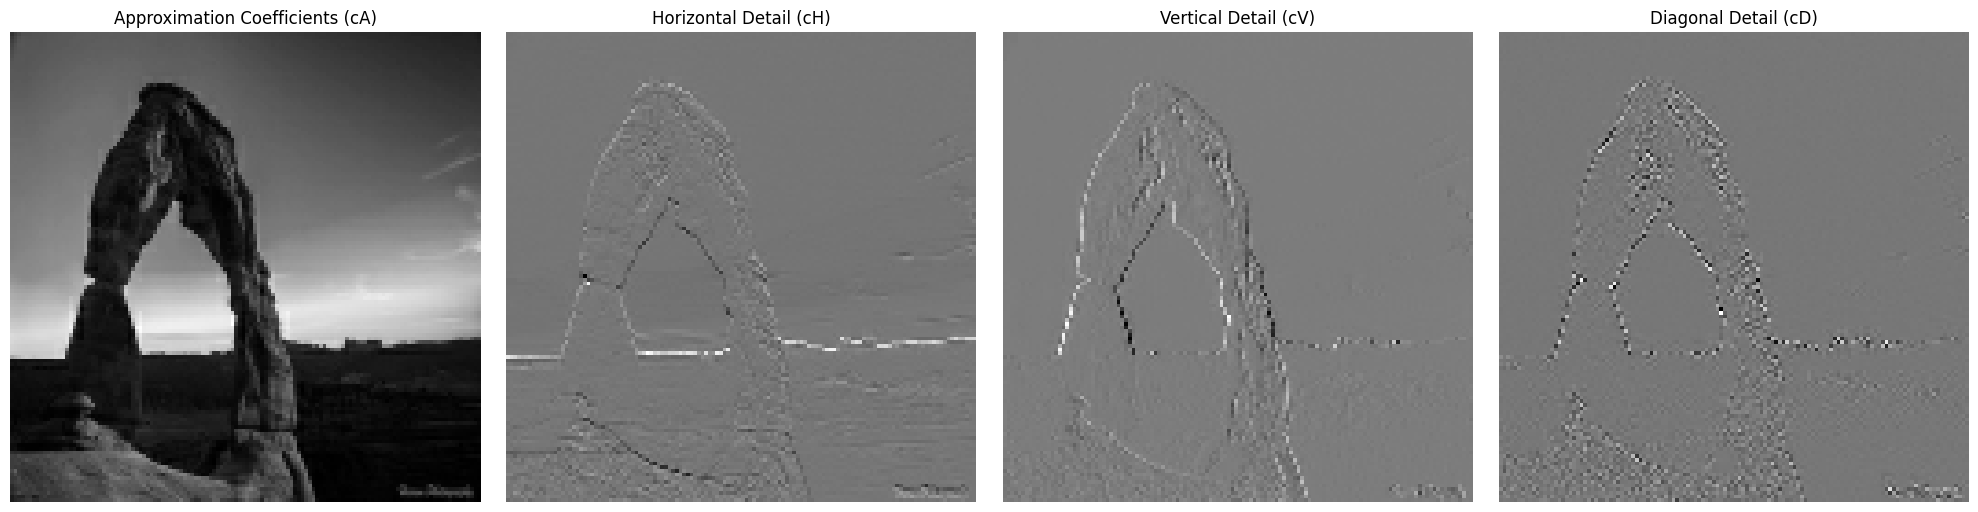

CPU times: user 908 ms, sys: 77 ms, total: 985 ms
Wall time: 1.08 s


In [56]:
%%time 

visualize_wavelet_from_ds(monet_image)
visualize_wavelet_from_ds(photo_image)

In [57]:
%%time

monet_energy, monet_std = wavelet_features_from_ds(monet_image)
photo_energy, photo_std = wavelet_features_from_ds(photo_image)

print(f"Monet Energy: {monet_energy:.2f}, Monet STD: {monet_std:.2f}")
print(f"Photo Energy: {photo_energy:.2f}, Photo STD: {photo_std:.2f}")


Monet Energy: 15347.41, Monet STD: 0.48
Photo Energy: 24292.23, Photo STD: 0.58
CPU times: user 5.26 ms, sys: 2.42 ms, total: 7.68 ms
Wall time: 5.95 ms


1/1 [==============================] - 1s 656ms/step


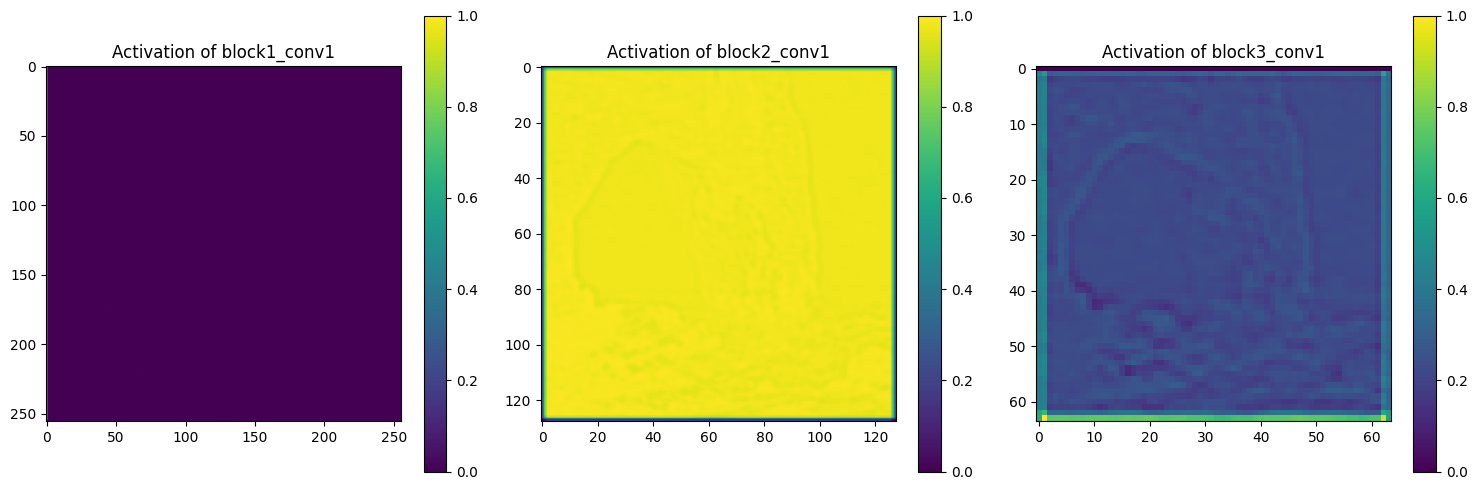

CPU times: user 2.03 s, sys: 856 ms, total: 2.89 s
Wall time: 3.5 s


In [58]:
%%time 

layer_names = ['block1_conv1', 'block2_conv1', 'block3_conv1']

monet_image_sample = np.expand_dims(next(iter(monet_dataset)).numpy()[0], axis=0)

features = extract_features(monet_image_sample, layer_names)


fig, axes = plt.subplots(1, len(layer_names), figsize=(15, 5))

for ax, layer_name, feature in zip(axes, layer_names, features):
    ax.imshow(feature[0, :, :, 0], cmap='viridis')
    ax.set_title(f"Activation of {layer_name}")
    fig.colorbar(plt.cm.ScalarMappable(cmap='viridis'), ax=ax)

plt.tight_layout()
plt.show()



In [59]:
red_stats = {"Mean": [], "Median": [], "Std": [], "Skewness": []}
green_stats = {"Mean": [], "Median": [], "Std": [], "Skewness": []}
blue_stats = {"Mean": [], "Median": [], "Std": [], "Skewness": []}

for batch_idx, batch in enumerate(monet_dataset):
    for image_idx, image in enumerate(batch):
        stats = image_statistics(image.numpy())

        red_stats["Mean"].append(stats["Red Mean"])
        red_stats["Median"].append(stats["Red Median"])
        red_stats["Std"].append(stats["Red Std"])
        red_stats["Skewness"].append(stats["Red Skewness"])

        green_stats["Mean"].append(stats["Green Mean"])
        green_stats["Median"].append(stats["Green Median"])
        green_stats["Std"].append(stats["Green Std"])
        green_stats["Skewness"].append(stats["Green Skewness"])

        blue_stats["Mean"].append(stats["Blue Mean"])
        blue_stats["Median"].append(stats["Blue Median"])
        blue_stats["Std"].append(stats["Blue Std"])
        blue_stats["Skewness"].append(stats["Blue Skewness"])

        table_data = [(key, f"{value:.2f}") for key, value in stats.items()]
        print(f"\nStats for Image {image_idx + 1} in Batch {batch_idx + 1}")
        print(tabulate(table_data, headers=['Metric', 'Value']))


Stats for Image 1 in Batch 1
Metric            Value
--------------  -------
Red Mean           0.11
Red Median         0.14
Red Std            0.5
Red Skewness      -0.34
Green Mean         0.2
Green Median       0.23
Green Std          0.45
Green Skewness    -0.49
Blue Mean          0.04
Blue Median        0.04
Blue Std           0.46
Blue Skewness     -0.34

Stats for Image 2 in Batch 1
Metric            Value
--------------  -------
Red Mean           0.14
Red Median         0.29
Red Std            0.52
Red Skewness      -0.26
Green Mean         0.14
Green Median       0.13
Green Std          0.29
Green Skewness     0.46
Blue Mean         -0.3
Blue Median       -0.3
Blue Std           0.13
Blue Skewness      0.34

Stats for Image 3 in Batch 1
Metric            Value
--------------  -------
Red Mean           0
Red Median        -0.04
Red Std            0.47
Red Skewness       0.12
Green Mean         0.1
Green Median       0.13
Green Std          0.4
Green Skewness    -0.32
Blue Me


Stats for Image 1 in Batch 2
Metric            Value
--------------  -------
Red Mean           0.35
Red Median         0.33
Red Std            0.33
Red Skewness      -0.25
Green Mean         0.43
Green Median       0.4
Green Std          0.28
Green Skewness    -0.23
Blue Mean          0.25
Blue Median        0.21
Blue Std           0.45
Blue Skewness     -0.24

Stats for Image 2 in Batch 2
Metric            Value
--------------  -------
Red Mean           0.19
Red Median         0.35
Red Std            0.45
Red Skewness      -0.71
Green Mean         0.09
Green Median       0.19
Green Std          0.46
Green Skewness    -0.53
Blue Mean         -0.06
Blue Median       -0
Blue Std           0.49
Blue Skewness     -0.26

Stats for Image 3 in Batch 2
Metric            Value
--------------  -------
Red Mean           0.22
Red Median         0.24
Red Std            0.45
Red Skewness      -0.18
Green Mean         0.14
Green Median       0.17
Green Std          0.42
Green Skewness    -0.25
Bl


Stats for Image 30 in Batch 2
Metric            Value
--------------  -------
Red Mean          -0.17
Red Median        -0.29
Red Std            0.46
Red Skewness       0.37
Green Mean        -0.18
Green Median      -0.27
Green Std          0.36
Green Skewness     0.27
Blue Mean         -0.13
Blue Median       -0.18
Blue Std           0.36
Blue Skewness      0.07

Stats for Image 31 in Batch 2
Metric            Value
--------------  -------
Red Mean           0.07
Red Median         0.03
Red Std            0.36
Red Skewness       0.2
Green Mean         0.26
Green Median       0.25
Green Std          0.3
Green Skewness    -0.08
Blue Mean          0.16
Blue Median        0.14
Blue Std           0.32
Blue Skewness     -0.04

Stats for Image 32 in Batch 2
Metric            Value
--------------  -------
Red Mean          -0.38
Red Median        -0.37
Red Std            0.22
Red Skewness      -0.12
Green Mean        -0.37
Green Median      -0.36
Green Std          0.2
Green Skewness    -0.4


Stats for Image 1 in Batch 4
Metric            Value
--------------  -------
Red Mean           0.15
Red Median         0.22
Red Std            0.44
Red Skewness      -0.57
Green Mean         0.04
Green Median       0.18
Green Std          0.48
Green Skewness    -0.4
Blue Mean         -0.22
Blue Median       -0.3
Blue Std           0.57
Blue Skewness      0.29

Stats for Image 2 in Batch 4
Metric            Value
--------------  -------
Red Mean           0.03
Red Median         0.02
Red Std            0.36
Red Skewness      -0.12
Green Mean         0.03
Green Median       0.07
Green Std          0.31
Green Skewness    -0.55
Blue Mean         -0.11
Blue Median       -0.02
Blue Std           0.34
Blue Skewness     -0.81

Stats for Image 3 in Batch 4
Metric            Value
--------------  -------
Red Mean           0.17
Red Median         0.11
Red Std            0.28
Red Skewness       0.74
Green Mean         0.2
Green Median       0.24
Green Std          0.23
Green Skewness    -0.61
B


Stats for Image 4 in Batch 5
Metric            Value
--------------  -------
Red Mean           0.12
Red Median         0.16
Red Std            0.35
Red Skewness      -0.74
Green Mean         0.07
Green Median       0.16
Green Std          0.35
Green Skewness    -1.02
Blue Mean          0.27
Blue Median        0.4
Blue Std           0.38
Blue Skewness     -1.72

Stats for Image 5 in Batch 5
Metric            Value
--------------  -------
Red Mean          -0.1
Red Median        -0.04
Red Std            0.41
Red Skewness      -0.37
Green Mean         0.06
Green Median       0.11
Green Std          0.36
Green Skewness    -0.32
Blue Mean          0.03
Blue Median        0.09
Blue Std           0.41
Blue Skewness     -0.39

Stats for Image 6 in Batch 5
Metric            Value
--------------  -------
Red Mean          -0.29
Red Median        -0.33
Red Std            0.35
Red Skewness       0.22
Green Mean        -0.25
Green Median      -0.24
Green Std          0.27
Green Skewness    -0.18



Stats for Image 10 in Batch 6
Metric            Value
--------------  -------
Red Mean           0.25
Red Median         0.29
Red Std            0.26
Red Skewness      -0.88
Green Mean         0.23
Green Median       0.29
Green Std          0.24
Green Skewness    -1.18
Blue Mean          0.2
Blue Median        0.25
Blue Std           0.25
Blue Skewness     -1.16

Stats for Image 11 in Batch 6
Metric            Value
--------------  -------
Red Mean           0.43
Red Median         0.53
Red Std            0.33
Red Skewness      -1.26
Green Mean         0.32
Green Median       0.44
Green Std          0.31
Green Skewness    -1.48
Blue Mean         -0.05
Blue Median       -0.05
Blue Std           0.33
Blue Skewness     -0.18

Stats for Image 12 in Batch 6
Metric            Value
--------------  -------
Red Mean          -0.16
Red Median        -0.25
Red Std            0.47
Red Skewness       0.69
Green Mean        -0.23
Green Median      -0.34
Green Std          0.46
Green Skewness     0


Stats for Image 19 in Batch 7
Metric            Value
--------------  -------
Red Mean          -0.04
Red Median        -0.04
Red Std            0.39
Red Skewness       0.05
Green Mean        -0.14
Green Median      -0.11
Green Std          0.34
Green Skewness    -0.24
Blue Mean         -0.37
Blue Median       -0.48
Blue Std           0.46
Blue Skewness      0.61

Stats for Image 20 in Batch 7
Metric            Value
--------------  -------
Red Mean           0.17
Red Median         0.18
Red Std            0.35
Red Skewness      -0.27
Green Mean         0.03
Green Median       0.04
Green Std          0.33
Green Skewness    -0.09
Blue Mean         -0.41
Blue Median       -0.52
Blue Std           0.39
Blue Skewness      1.01

Stats for Image 21 in Batch 7
Metric            Value
--------------  -------
Red Mean          -0.22
Red Median        -0.28
Red Std            0.38
Red Skewness       0.72
Green Mean        -0.3
Green Median      -0.36
Green Std          0.32
Green Skewness     1


Stats for Image 24 in Batch 8
Metric            Value
--------------  -------
Red Mean          -0.22
Red Median        -0.27
Red Std            0.35
Red Skewness       0.53
Green Mean        -0.33
Green Median      -0.38
Green Std          0.3
Green Skewness     0.78
Blue Mean         -0.67
Blue Median       -0.74
Blue Std           0.26
Blue Skewness      1.12

Stats for Image 25 in Batch 8
Metric            Value
--------------  -------
Red Mean           0.23
Red Median         0.27
Red Std            0.32
Red Skewness      -0.69
Green Mean         0.36
Green Median       0.43
Green Std          0.29
Green Skewness    -1.63
Blue Mean          0.37
Blue Median        0.44
Blue Std           0.27
Blue Skewness     -1.89

Stats for Image 26 in Batch 8
Metric            Value
--------------  -------
Red Mean           0.45
Red Median         0.52
Red Std            0.25
Red Skewness      -1.19
Green Mean         0.6
Green Median       0.65
Green Std          0.19
Green Skewness    -1.


Stats for Image 30 in Batch 9
Metric            Value
--------------  -------
Red Mean          -0.25
Red Median        -0.3
Red Std            0.41
Red Skewness       0.46
Green Mean        -0.26
Green Median      -0.29
Green Std          0.34
Green Skewness     0.41
Blue Mean         -0.49
Blue Median       -0.51
Blue Std           0.23
Blue Skewness      0.88

Stats for Image 31 in Batch 9
Metric            Value
--------------  -------
Red Mean          -0.03
Red Median         0.07
Red Std            0.61
Red Skewness      -0.22
Green Mean         0.09
Green Median       0.04
Green Std          0.57
Green Skewness    -0.07
Blue Mean          0.13
Blue Median        0.09
Blue Std           0.46
Blue Skewness     -0.02

Stats for Image 32 in Batch 9
Metric            Value
--------------  -------
Red Mean          -0.03
Red Median        -0.03
Red Std            0.35
Red Skewness       0.04
Green Mean         0.03
Green Median       0.06
Green Std          0.29
Green Skewness    -0

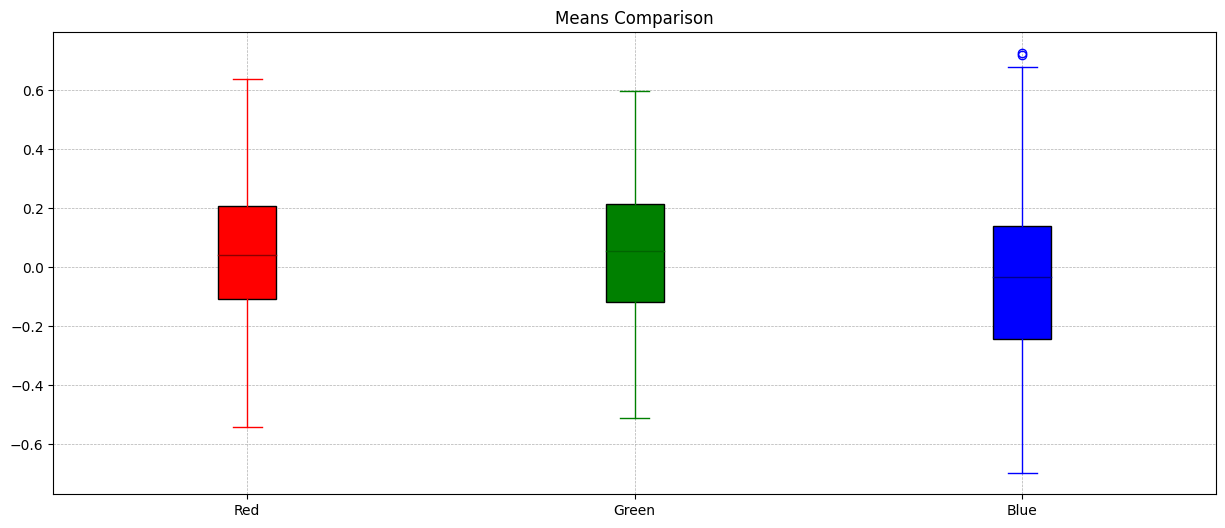

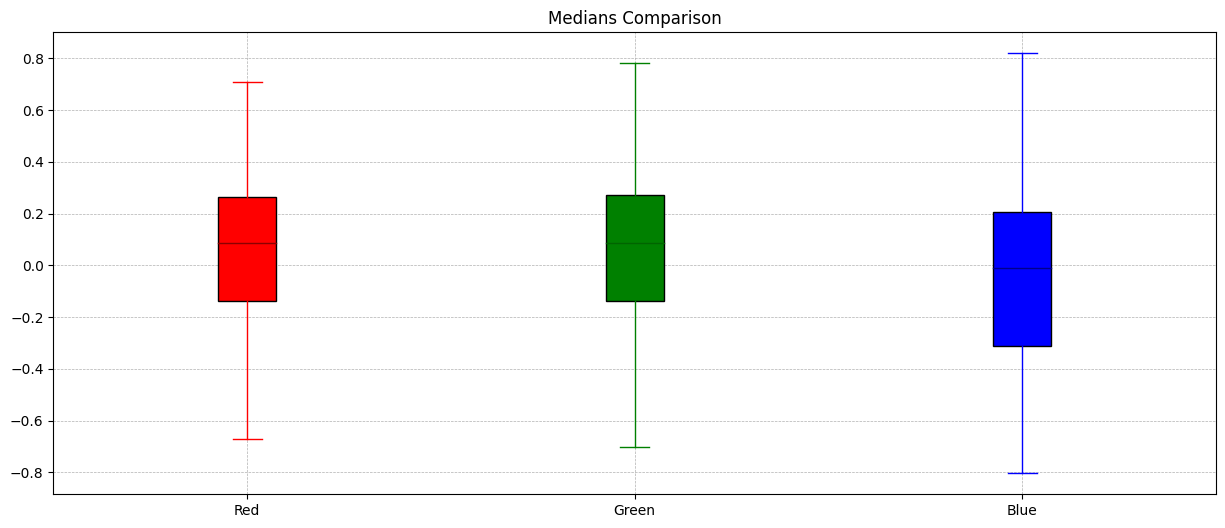

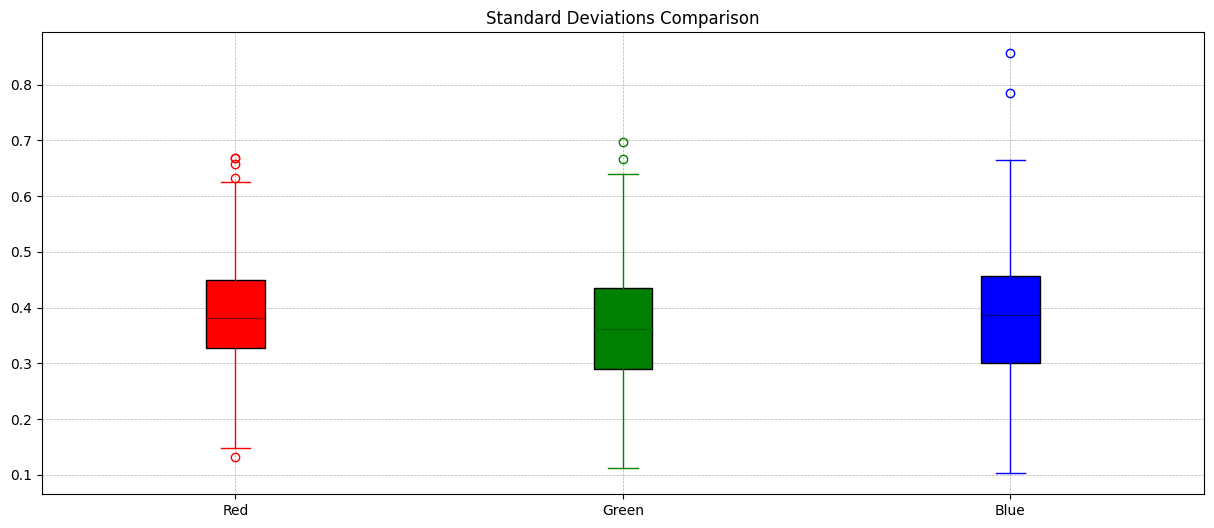

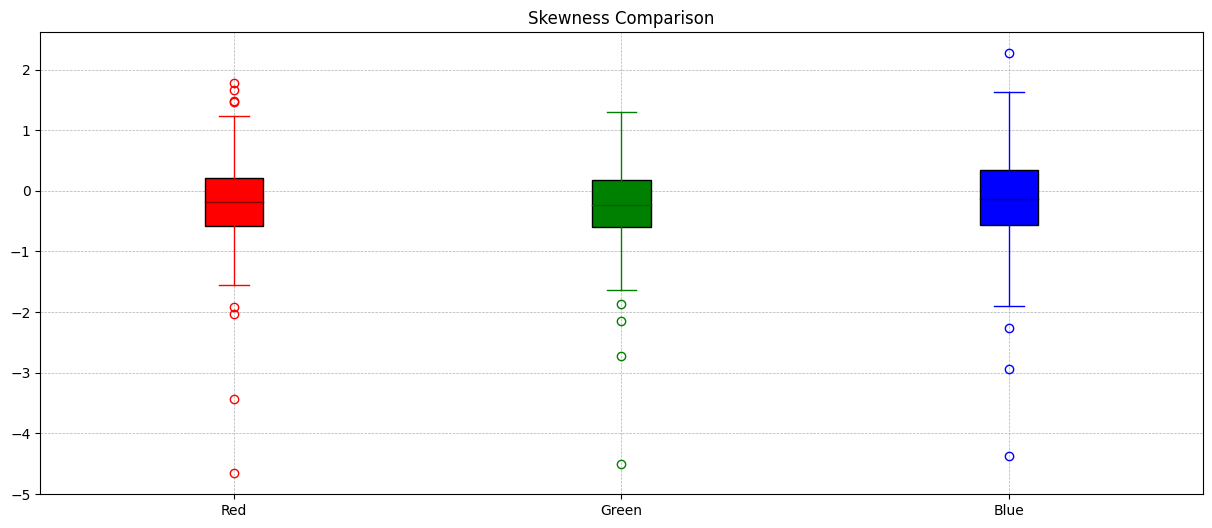

In [60]:
plot_boxplots_together(red_stats["Mean"], green_stats["Mean"], blue_stats["Mean"], "Means Comparison")
plot_boxplots_together(red_stats["Median"], green_stats["Median"], blue_stats["Median"], "Medians Comparison")
plot_boxplots_together(red_stats["Std"], green_stats["Std"], blue_stats["Std"], "Standard Deviations Comparison")
plot_boxplots_together(red_stats["Skewness"], green_stats["Skewness"], blue_stats["Skewness"], "Skewness Comparison")

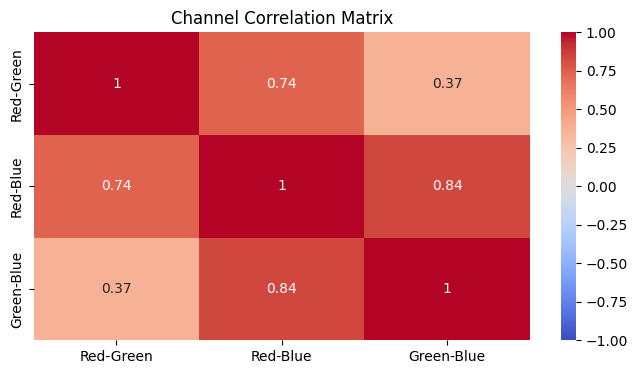

In [61]:
red_green_correlations = []
red_blue_correlations = []
green_blue_correlations = []

for batch in monet_dataset:
    for image in batch:
        image_np = image.numpy()
        correlations = channel_correlation(image_np)

        red_green_correlations.append(correlations['Red-Green Correlation'])
        red_blue_correlations.append(correlations['Red-Blue Correlation'])
        green_blue_correlations.append(correlations['Green-Blue Correlation'])

df = pd.DataFrame({
    'Red-Green': red_green_correlations,
    'Red-Blue': red_blue_correlations,
    'Green-Blue': green_blue_correlations
})

corr_matrix = df.corr()

plt.figure(figsize=(8, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Channel Correlation Matrix")
plt.show()

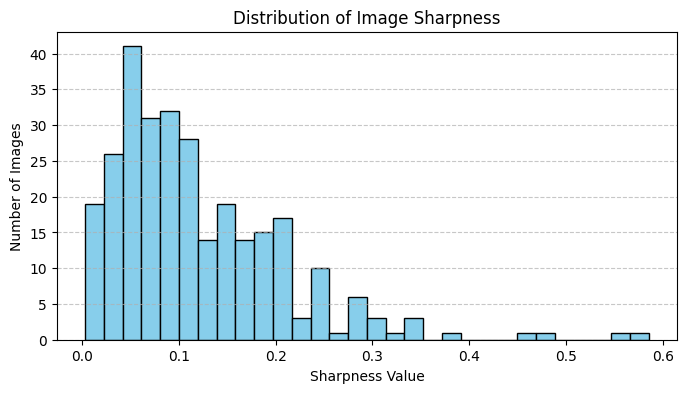

In [62]:
sharpness_values = []

for batch in monet_dataset:
    for image in batch:
        sharpness = compute_sharpness(image)
        sharpness_values.append(sharpness)

plt.figure(figsize=(8, 4))
plt.hist(sharpness_values, bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution of Image Sharpness")
plt.xlabel("Sharpness Value")
plt.ylabel("Number of Images")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#### Conclusion: 
There's an offset in the general brightness between the Monet paintings and regular photos.
Monet paintings might have more consistent or less variable pixel intensities.

### Built Model

#### model's architecture

The model is divided into two integral components: 
    
    - The Generator: adept at capturing and recreating image nuances;
    - The Discriminator: its role is to discern whether an image is authentic or synthesized.
        
The model employs a series of loss functions, ensuring that the output is not only of high quality but also remains faithful to the original content.
For tasks such as morphing standard photos into Monet-inspired visuals (or vice versa), CycleGAN stands out as a prime choice.
To cap it off, the incorporation of techniques like early stopping streamlines and optimizes the training journey, ensuring efficiency and precision.

In [64]:
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

CHANNELS_OUTPUT = 3
cycle_loss_weight = 10
identity_loss_weight = 0.5

The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [5]:
def down_block(filters: int, kernel_size: int, use_instance_norm=True) -> keras.Sequential:
    
    """
    Constructs a downsampling block with given filters, kernel size and instance normalization option.
    """
    
    init = tf.random_normal_initializer(0., 0.02)
    gamma_initializer = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    block = keras.Sequential()
    block.add(layers.Conv2D(filters, kernel_size, strides=2, padding='same', kernel_initializer=init, use_bias=False))

    if use_instance_norm:
        block.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer))
    
    block.add(layers.LeakyReLU())

    return block


def up_block(filters: int, kernel_size: int, dropout=False) -> keras.Sequential:
    
    """
    Constructs an upsampling block with given filters, kernel size and dropout option.
    """
    
    init = tf.random_normal_initializer(0., 0.02)
    gamma_initializer = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    block = keras.Sequential()
    block.add(layers.Conv2DTranspose(filters, kernel_size, strides=2, padding='same', kernel_initializer=init, use_bias=False))

    block.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer))

    if dropout:
        block.add(layers.Dropout(0.5))

    block.add(layers.ReLU())

    return block

def build_generator() -> keras.Model:
    
    """
    Constructs the generator model for the GAN.
    """
    
    input_tensor = layers.Input(shape=[256,256,3])

    down_blocks = [
        down_block(64, 4, use_instance_norm=False),
        down_block(128, 4),
        down_block(256, 4),
        down_block(512, 4),
        down_block(512, 4),
        down_block(512, 4),
        down_block(512, 4),
        down_block(512, 4)
    ]

    up_blocks = [
        up_block(512, 4, dropout=True),
        up_block(512, 4, dropout=True),
        up_block(512, 4, dropout=True),
        up_block(512, 4),
        up_block(256, 4),
        up_block(128, 4),
        up_block(64, 4)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last_layer = layers.Conv2DTranspose(CHANNELS_OUTPUT, 4, strides=2, padding='same', kernel_initializer=initializer, activation='tanh')

    x = input_tensor
    skip_connections = []
    for block in down_blocks:
        x = block(x)
        skip_connections.append(x)

    skip_connections = reversed(skip_connections[:-1])

    for block, skip in zip(up_blocks, skip_connections):
        x = block(x)
        x = layers.Concatenate()([x, skip])

    x = last_layer(x)

    return keras.Model(inputs=input_tensor, outputs=x)

def build_discriminator() -> keras.Model:
    
    """
    Constructs the discriminator model for the GAN.
    """
    
    init = tf.random_normal_initializer(0., 0.02)
    gamma_initializer = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    input_tensor = layers.Input(shape=[256, 256, 3])

    x = input_tensor
    x = down_block(64, 4, use_instance_norm=False)(x)
    x = down_block(128, 4)(x)
    x = down_block(256, 4)(x)

    x = layers.ZeroPadding2D()(x)
    x = layers.Conv2D(512, 4, strides=1, kernel_initializer=init, use_bias=False)(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.LeakyReLU()(x)
    x = layers.ZeroPadding2D()(x)
    x = layers.Conv2D(1, 4, strides=1, kernel_initializer=init)(x)

    return keras.Model(inputs=input_tensor, outputs=x)


with strategy.scope():
    monet_gen = build_generator()
    photo_gen = build_generator()
    monet_disc = build_discriminator()
    photo_disc = build_discriminator()

    
with strategy.scope():
    
    def disc_loss(real: tf.Tensor, fake: tf.Tensor) -> tf.Tensor:
        
        """
        Calculate the discriminator loss using binary cross-entropy.
        """
        
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)
        fake_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(fake), fake)
        
        return (real_loss + fake_loss) * 0.5

    def gen_loss(fake_output: tf.Tensor) -> tf.Tensor:
        
        """
        Calculate the generator loss using binary cross-entropy.
        """
        
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(fake_output), fake_output)

    def calculate_cycle_loss(original_img: tf.Tensor, cycled_img: tf.Tensor, LAMBDA: int = 10) -> tf.Tensor:
        
        """
        Calculate the cycle consistency loss.
        """
        
        return LAMBDA * tf.reduce_mean(tf.abs(original_img - cycled_img))

    def calculate_identity_loss(original_img: tf.Tensor, same_img: tf.Tensor, LAMBDA: int = 10) -> tf.Tensor:
    
        """
        Calculate the identity loss.
        """
        
        return LAMBDA * 0.5 * tf.reduce_mean(tf.abs(original_img - same_img))

    monet_gen_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_gen_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    monet_disc_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_disc_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)



In [63]:
@tf.function

def train_step(monet_img_batch: tf.Tensor, photo_img_batch: tf.Tensor):
    
    """
    Perform a single training step for the CycleGAN.
    """

    with tf.GradientTape(persistent=True) as tape:
        
        fake_photo = monet_gen(monet_img_batch, training=True)
        cycled_monet = photo_gen(fake_photo, training=True)
        same_monet = monet_gen(monet_img_batch, training=True)

        fake_monet = photo_gen(photo_img_batch, training=True)
        cycled_photo = photo_gen(fake_monet, training=True)
        same_photo = photo_gen(photo_img_batch, training=True)

        disc_real_monet = monet_disc(monet_img_batch, training=True)
        disc_fake_monet = monet_disc(fake_monet, training=True)
        disc_real_photo = photo_disc(photo_img_batch, training=True)
        disc_fake_photo = photo_disc(fake_photo, training=True)

        monet_gen_loss = gen_loss(disc_fake_monet)
        photo_gen_loss = gen_loss(disc_fake_photo)

        total_cycle_loss = calculate_cycle_loss(monet_img_batch, cycled_monet) + calculate_cycle_loss(photo_img_batch, cycled_photo)

        total_monet_gen_loss = monet_gen_loss + total_cycle_loss + calculate_identity_loss(monet_img_batch, same_monet)
        total_photo_gen_loss = photo_gen_loss + total_cycle_loss + calculate_identity_loss(photo_img_batch, same_photo)

        monet_disc_loss = disc_loss(disc_real_monet, disc_fake_monet)
        photo_disc_loss = disc_loss(disc_real_photo, disc_fake_photo)

        monet_gen_gradients = tape.gradient(total_monet_gen_loss, monet_gen.trainable_variables)
        photo_gen_gradients = tape.gradient(total_photo_gen_loss, photo_gen.trainable_variables)

        monet_disc_gradients = tape.gradient(monet_disc_loss, monet_disc.trainable_variables)
        photo_disc_gradients = tape.gradient(photo_disc_loss, photo_disc.trainable_variables)

        monet_gen_optimizer.apply_gradients(zip(monet_gen_gradients, monet_gen.trainable_variables))
        photo_gen_optimizer.apply_gradients(zip(photo_gen_gradients, photo_gen.trainable_variables))
        monet_disc_optimizer.apply_gradients(zip(monet_disc_gradients, monet_disc.trainable_variables))
        photo_disc_optimizer.apply_gradients(zip(photo_disc_gradients, photo_disc.trainable_variables))

        del tape
        

def train(dataset, epochs: int):
    
    """
    Train the CycleGAN for a specified number of epochs.
    """

    for epoch in tqdm(range(epochs), desc="Epochs"):
        for monet_img_batch, photo_img_batch in tqdm(dataset, desc=f"Epoch {epoch+1}", leave=False):  # Nested tqdm for batches
            train_step(monet_img_batch, photo_img_batch)

        checkpoint_save_path = checkpoint_manager.save()
        print(f"Saved checkpoint for epoch {epoch+1}: {checkpoint_save_path}")


In [6]:
checkpoint = tf.train.Checkpoint(
    monet_gen_optimizer=monet_gen_optimizer,
    photo_gen_optimizer=photo_gen_optimizer,
    monet_disc_optimizer=monet_disc_optimizer,
    photo_disc_optimizer=photo_disc_optimizer,
    monet_gen=monet_gen,
    photo_gen=photo_gen,
    monet_disc=monet_disc,
    photo_disc=photo_disc
)

checkpoint_dir = '/Users/flaviab/Downloads/gan-getting-started/checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint_manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=3)  

if checkpoint_manager.latest_checkpoint:
    checkpoint.restore(checkpoint_manager.latest_checkpoint)
    print("Restored from the latest checkpoint!")
else:
    print("Training from scratch.")

Restored from the latest checkpoint!


In [7]:
monet_gen_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
photo_gen_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
monet_disc_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
photo_disc_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

monet_gen = build_generator()
photo_gen = build_generator()
monet_disc = build_discriminator()
photo_disc = build_discriminator()

In [8]:
dataset = tf.data.Dataset.zip((monet_dataset, photo_dataset))

In [9]:
%%time

metrics = train(dataset, 40)


Epochs:   0%|                                            | 0/40 [00:00<?, ?it/s]
Epoch 1: 0it [00:00, ?it/s]


Epoch 1: 1it [01:24, 84.82s/it]
Epoch 1: 2it [02:17, 65.62s/it]
Epoch 1: 3it [03:05, 57.80s/it]
Epoch 1: 4it [03:55, 54.74s/it]
Epoch 1: 5it [04:45, 53.16s/it]
Epoch 1: 6it [05:34, 51.50s/it]
Epoch 1: 7it [06:23, 50.65s/it]
Epoch 1: 8it [07:12, 50.14s/it]
Epoch 1: 9it [08:01, 49.76s/it]
Epochs:   2%|▊                                | 1/40 [08:04<5:15:06, 484.78s/it]

Saved checkpoint for epoch 1: /Users/flaviab/Downloads/gan-getting-started/checkpoints/ckpt-2



Epoch 2: 0it [00:00, ?it/s]
Epoch 2: 1it [00:48, 48.89s/it]
Epoch 2: 2it [01:38, 49.39s/it]
Epoch 2: 3it [02:26, 48.91s/it]
Epoch 2: 4it [03:15, 48.77s/it]
Epoch 2: 5it [04:04, 48.78s/it]
Epoch 2: 6it [04:52, 48.52s/it]
Epoch 2: 7it [05:40, 48.24s/it]
Epoch 2: 8it [06:30, 49.00s/it]
Epoch 2: 9it [07:18, 48.57s/it]
Epochs:   5%|█▋                               | 2/40 [15:26<4:50:53, 459.30s/it]

Saved checkpoint for epoch 2: /Users/flaviab/Downloads/gan-getting-started/checkpoints/ckpt-3



Epoch 3: 0it [00:00, ?it/s]
Epoch 3: 1it [00:50, 50.04s/it]
Epoch 3: 2it [01:42, 51.58s/it]
Epoch 3: 3it [02:31, 50.37s/it]
Epoch 3: 4it [03:22, 50.52s/it]
Epoch 3: 5it [04:12, 50.45s/it]
Epoch 3: 6it [04:59, 49.37s/it]
Epoch 3: 7it [05:50, 49.68s/it]
Epoch 3: 8it [06:37, 49.05s/it]
Epoch 3: 9it [07:28, 49.54s/it]
Epochs:   8%|██▍                              | 3/40 [22:57<4:41:02, 455.74s/it]

Saved checkpoint for epoch 3: /Users/flaviab/Downloads/gan-getting-started/checkpoints/ckpt-4



Epoch 4: 0it [00:00, ?it/s]
Epoch 4: 1it [00:50, 50.23s/it]
Epoch 4: 2it [01:40, 50.11s/it]
Epoch 4: 3it [02:28, 49.48s/it]
Epoch 4: 4it [03:18, 49.52s/it]
Epoch 4: 5it [04:07, 49.19s/it]
Epoch 4: 6it [04:55, 48.85s/it]
Epoch 4: 7it [05:47, 49.78s/it]
Epoch 4: 8it [06:35, 49.46s/it]
Epoch 4: 9it [07:24, 49.28s/it]
Epochs:  10%|███▎                             | 4/40 [30:25<4:31:29, 452.50s/it]

Saved checkpoint for epoch 4: /Users/flaviab/Downloads/gan-getting-started/checkpoints/ckpt-5



Epoch 5: 0it [00:00, ?it/s]
Epoch 5: 1it [00:50, 50.80s/it]
Epoch 5: 2it [01:40, 50.19s/it]
Epoch 5: 3it [02:30, 49.91s/it]
Epoch 5: 4it [03:19, 49.71s/it]
Epoch 5: 5it [04:11, 50.37s/it]
Epoch 5: 6it [04:59, 49.67s/it]
Epoch 5: 7it [05:48, 49.61s/it]
Epoch 5: 8it [06:37, 49.38s/it]
Epoch 5: 9it [07:25, 48.97s/it]
Epochs:  12%|████▏                            | 5/40 [37:54<4:23:10, 451.15s/it]

Saved checkpoint for epoch 5: /Users/flaviab/Downloads/gan-getting-started/checkpoints/ckpt-6



Epoch 6: 0it [00:00, ?it/s]
Epoch 6: 1it [00:52, 52.87s/it]
Epoch 6: 2it [01:42, 50.92s/it]
Epoch 6: 3it [02:31, 49.97s/it]
Epoch 6: 4it [03:19, 49.30s/it]
Epoch 6: 5it [04:08, 49.08s/it]
Epoch 6: 6it [04:57, 49.31s/it]
Epoch 6: 7it [05:47, 49.24s/it]
Epoch 6: 8it [06:35, 48.92s/it]
Epoch 6: 9it [07:22, 48.43s/it]
Epochs:  15%|████▉                            | 6/40 [45:19<4:14:35, 449.29s/it]

Saved checkpoint for epoch 6: /Users/flaviab/Downloads/gan-getting-started/checkpoints/ckpt-7



Epoch 7: 0it [00:00, ?it/s]
Epoch 7: 1it [00:52, 52.39s/it]
Epoch 7: 2it [01:40, 50.05s/it]
Epoch 7: 3it [02:30, 50.01s/it]
Epoch 7: 4it [03:20, 49.84s/it]
Epoch 7: 5it [04:09, 49.51s/it]
Epoch 7: 6it [04:57, 49.09s/it]
Epoch 7: 7it [05:46, 49.07s/it]
Epoch 7: 8it [06:37, 49.52s/it]
Epoch 7: 9it [07:25, 49.08s/it]
Epochs:  18%|█████▊                           | 7/40 [52:47<4:06:55, 448.95s/it]

Saved checkpoint for epoch 7: /Users/flaviab/Downloads/gan-getting-started/checkpoints/ckpt-8



Epoch 8: 0it [00:00, ?it/s]
Epoch 8: 1it [00:49, 49.37s/it]
Epoch 8: 2it [01:39, 49.68s/it]
Epoch 8: 3it [02:29, 50.08s/it]
Epoch 8: 4it [03:21, 50.76s/it]
Epoch 8: 5it [04:12, 50.68s/it]
Epoch 8: 6it [05:03, 51.06s/it]
Epoch 8: 7it [05:52, 50.28s/it]
Epoch 8: 8it [06:42, 50.30s/it]
Epoch 8: 9it [07:30, 49.49s/it]
Epochs:  20%|██████▏                        | 8/40 [1:00:21<4:00:16, 450.53s/it]

Saved checkpoint for epoch 8: /Users/flaviab/Downloads/gan-getting-started/checkpoints/ckpt-9



Epoch 9: 0it [00:00, ?it/s]
Epoch 9: 1it [00:50, 50.20s/it]
Epoch 9: 2it [01:43, 51.90s/it]
Epoch 9: 3it [02:31, 50.43s/it]
Epoch 9: 4it [03:22, 50.40s/it]
Epoch 9: 5it [04:13, 50.69s/it]
Epoch 9: 6it [05:01, 49.70s/it]
Epoch 9: 7it [05:51, 49.72s/it]
Epoch 9: 8it [06:38, 49.14s/it]
Epoch 9: 9it [07:29, 49.63s/it]
Epochs:  22%|██████▉                        | 9/40 [1:07:54<3:53:07, 451.20s/it]

Saved checkpoint for epoch 9: /Users/flaviab/Downloads/gan-getting-started/checkpoints/ckpt-10



Epoch 10: 0it [00:00, ?it/s]
Epoch 10: 1it [00:49, 49.71s/it]
Epoch 10: 2it [01:39, 49.90s/it]
Epoch 10: 3it [02:28, 49.46s/it]
Epoch 10: 4it [03:16, 49.01s/it]
Epoch 10: 5it [04:06, 49.36s/it]
Epoch 10: 6it [04:56, 49.28s/it]
Epoch 10: 7it [05:46, 49.67s/it]
Epoch 10: 8it [06:38, 50.50s/it]
Epoch 10: 9it [07:29, 50.45s/it]
Epochs:  25%|███████▌                      | 10/40 [1:15:26<3:45:44, 451.49s/it]

Saved checkpoint for epoch 10: /Users/flaviab/Downloads/gan-getting-started/checkpoints/ckpt-11



Epoch 11: 0it [00:00, ?it/s]
Epoch 11: 1it [00:51, 51.35s/it]
Epoch 11: 2it [01:43, 51.58s/it]
Epoch 11: 3it [02:31, 50.19s/it]
Epoch 11: 4it [03:20, 49.80s/it]
Epoch 11: 5it [04:11, 50.10s/it]
Epoch 11: 6it [04:59, 49.46s/it]
Epoch 11: 7it [05:49, 49.54s/it]
Epoch 11: 8it [06:38, 49.53s/it]
Epoch 11: 9it [07:27, 49.15s/it]
Epochs:  28%|████████▎                     | 11/40 [1:22:56<3:38:00, 451.06s/it]

Saved checkpoint for epoch 11: /Users/flaviab/Downloads/gan-getting-started/checkpoints/ckpt-12



Epoch 12: 0it [00:00, ?it/s]
Epoch 12: 1it [00:50, 50.86s/it]
Epoch 12: 2it [01:42, 51.22s/it]
Epoch 12: 3it [02:30, 49.97s/it]
Epoch 12: 4it [03:19, 49.48s/it]
Epoch 12: 5it [04:08, 49.15s/it]
Epoch 12: 6it [04:58, 49.56s/it]
Epoch 12: 7it [05:47, 49.32s/it]
Epoch 12: 8it [06:38, 49.84s/it]
Epoch 12: 9it [07:28, 49.82s/it]
Epochs:  30%|█████████                     | 12/40 [1:30:27<3:30:30, 451.09s/it]

Saved checkpoint for epoch 12: /Users/flaviab/Downloads/gan-getting-started/checkpoints/ckpt-13



Epoch 13: 0it [00:00, ?it/s]
Epoch 13: 1it [00:48, 48.84s/it]
Epoch 13: 2it [01:40, 50.53s/it]
Epoch 13: 3it [02:27, 49.01s/it]
Epoch 13: 4it [03:16, 49.03s/it]
Epoch 13: 5it [04:06, 49.20s/it]
Epoch 13: 6it [04:55, 49.19s/it]
Epoch 13: 7it [05:46, 49.93s/it]
Epoch 13: 8it [06:34, 49.31s/it]
Epoch 13: 9it [07:24, 49.38s/it]
Epochs:  32%|█████████▊                    | 13/40 [1:37:55<3:22:28, 449.93s/it]

Saved checkpoint for epoch 13: /Users/flaviab/Downloads/gan-getting-started/checkpoints/ckpt-14



Epoch 14: 0it [00:00, ?it/s]
Epoch 14: 1it [00:49, 49.67s/it]
Epoch 14: 2it [01:38, 49.30s/it]
Epoch 14: 3it [02:27, 49.05s/it]
Epoch 14: 4it [03:15, 48.73s/it]
Epoch 14: 5it [04:06, 49.44s/it]
Epoch 14: 6it [04:56, 49.57s/it]
Epoch 14: 7it [05:46, 49.70s/it]
Epoch 14: 8it [06:35, 49.72s/it]
Epoch 14: 9it [07:23, 49.06s/it]
Epochs:  35%|██████████▌                   | 14/40 [1:45:21<3:14:32, 448.93s/it]

Saved checkpoint for epoch 14: /Users/flaviab/Downloads/gan-getting-started/checkpoints/ckpt-15



Epoch 15: 0it [00:00, ?it/s]
Epoch 15: 1it [00:51, 51.03s/it]
Epoch 15: 2it [01:41, 50.53s/it]
Epoch 15: 3it [02:31, 50.52s/it]
Epoch 15: 4it [03:20, 49.70s/it]
Epoch 15: 5it [04:09, 49.61s/it]
Epoch 15: 6it [04:56, 48.79s/it]
Epoch 15: 7it [05:46, 48.99s/it]
Epoch 15: 8it [06:34, 48.85s/it]
Epoch 15: 9it [07:23, 48.92s/it]
Epochs:  38%|███████████▎                  | 15/40 [1:52:48<3:06:46, 448.26s/it]

Saved checkpoint for epoch 15: /Users/flaviab/Downloads/gan-getting-started/checkpoints/ckpt-16



Epoch 16: 0it [00:00, ?it/s]
Epoch 16: 1it [00:50, 50.23s/it]
Epoch 16: 2it [01:38, 49.13s/it]
Epoch 16: 3it [02:29, 49.91s/it]
Epoch 16: 4it [03:20, 50.31s/it]
Epoch 16: 5it [04:10, 50.21s/it]
Epoch 16: 6it [04:59, 49.85s/it]
Epoch 16: 7it [05:49, 49.93s/it]
Epoch 16: 8it [06:39, 49.84s/it]
Epoch 16: 9it [07:26, 49.13s/it]
Epochs:  40%|████████████                  | 16/40 [2:00:18<2:59:29, 448.74s/it]

Saved checkpoint for epoch 16: /Users/flaviab/Downloads/gan-getting-started/checkpoints/ckpt-17



Epoch 17: 0it [00:00, ?it/s]
Epoch 17: 1it [00:50, 50.83s/it]
Epoch 17: 2it [01:48, 54.74s/it]
Epoch 17: 3it [02:43, 55.14s/it]
Epoch 17: 4it [03:34, 53.30s/it]
Epoch 17: 5it [04:20, 50.83s/it]
Epoch 17: 6it [05:08, 49.85s/it]
Epoch 17: 7it [05:58, 49.79s/it]
Epoch 17: 8it [06:47, 49.49s/it]
Epoch 17: 9it [07:35, 49.17s/it]
Epochs:  42%|████████████▊                 | 17/40 [2:07:57<2:53:10, 451.74s/it]

Saved checkpoint for epoch 17: /Users/flaviab/Downloads/gan-getting-started/checkpoints/ckpt-18



Epoch 18: 0it [00:00, ?it/s]
Epoch 18: 1it [00:48, 48.88s/it]
Epoch 18: 2it [01:37, 48.55s/it]
Epoch 18: 3it [02:25, 48.55s/it]
Epoch 18: 4it [03:16, 49.29s/it]
Epoch 18: 5it [04:05, 49.17s/it]
Epoch 18: 6it [04:54, 49.13s/it]
Epoch 18: 7it [05:42, 48.81s/it]
Epoch 18: 8it [06:32, 49.27s/it]
Epoch 18: 9it [07:21, 49.20s/it]
Epochs:  45%|█████████████▌                | 18/40 [2:15:21<2:44:51, 449.61s/it]

Saved checkpoint for epoch 18: /Users/flaviab/Downloads/gan-getting-started/checkpoints/ckpt-19



Epoch 19: 0it [00:00, ?it/s]
Epoch 19: 1it [00:50, 50.15s/it]
Epoch 19: 2it [01:40, 50.24s/it]
Epoch 19: 3it [02:32, 51.14s/it]
Epoch 19: 4it [03:23, 51.04s/it]
Epoch 19: 5it [04:13, 50.71s/it]
Epoch 19: 6it [05:03, 50.36s/it]
Epoch 19: 7it [05:51, 49.76s/it]
Epoch 19: 8it [06:40, 49.53s/it]
Epoch 19: 9it [07:28, 48.93s/it]
Epochs:  48%|██████████████▎               | 19/40 [2:22:53<2:37:33, 450.17s/it]

Saved checkpoint for epoch 19: /Users/flaviab/Downloads/gan-getting-started/checkpoints/ckpt-20



Epoch 20: 0it [00:00, ?it/s]
Epoch 20: 1it [00:50, 50.64s/it]
Epoch 20: 2it [01:40, 50.23s/it]
Epoch 20: 3it [02:29, 49.79s/it]
Epoch 20: 4it [03:19, 49.60s/it]
Epoch 20: 5it [04:08, 49.37s/it]
Epoch 20: 6it [04:57, 49.27s/it]
Epoch 20: 7it [05:46, 49.27s/it]
Epoch 20: 8it [06:34, 48.83s/it]
Epoch 20: 9it [07:23, 49.05s/it]
Epochs:  50%|███████████████               | 20/40 [2:30:20<2:29:44, 449.23s/it]

Saved checkpoint for epoch 20: /Users/flaviab/Downloads/gan-getting-started/checkpoints/ckpt-21



Epoch 21: 0it [00:00, ?it/s]
Epoch 21: 1it [00:50, 50.26s/it]
Epoch 21: 2it [01:37, 48.35s/it]
Epoch 21: 3it [02:25, 48.34s/it]
Epoch 21: 4it [03:16, 49.25s/it]
Epoch 21: 5it [04:06, 49.75s/it]
Epoch 21: 6it [04:56, 49.65s/it]
Epoch 21: 7it [05:46, 49.95s/it]
Epoch 21: 8it [06:37, 50.05s/it]
Epoch 21: 9it [07:27, 50.26s/it]
Epochs:  52%|███████████████▊              | 21/40 [2:37:50<2:22:23, 449.66s/it]

Saved checkpoint for epoch 21: /Users/flaviab/Downloads/gan-getting-started/checkpoints/ckpt-22



Epoch 22: 0it [00:00, ?it/s]
Epoch 22: 1it [00:49, 49.40s/it]
Epoch 22: 2it [01:38, 49.51s/it]
Epoch 22: 3it [02:29, 49.89s/it]
Epoch 22: 4it [03:18, 49.57s/it]
Epoch 22: 5it [04:08, 49.91s/it]
Epoch 22: 6it [04:58, 49.92s/it]
Epoch 22: 7it [05:48, 49.79s/it]
Epoch 22: 8it [06:38, 49.86s/it]
Epoch 22: 9it [07:26, 49.25s/it]
Epochs:  55%|████████████████▌             | 22/40 [2:45:20<2:14:51, 449.52s/it]

Saved checkpoint for epoch 22: /Users/flaviab/Downloads/gan-getting-started/checkpoints/ckpt-23



Epoch 23: 0it [00:00, ?it/s]
Epoch 23: 1it [00:50, 50.64s/it]
Epoch 23: 2it [01:40, 49.94s/it]
Epoch 23: 3it [02:30, 50.10s/it]
Epoch 23: 4it [03:17, 49.02s/it]
Epoch 23: 5it [04:06, 48.96s/it]
Epoch 23: 6it [04:56, 49.39s/it]
Epoch 23: 7it [05:45, 49.25s/it]
Epoch 23: 8it [06:35, 49.44s/it]
Epoch 23: 9it [07:23, 49.04s/it]
Epochs:  57%|█████████████████▎            | 23/40 [2:52:46<2:07:07, 448.69s/it]

Saved checkpoint for epoch 23: /Users/flaviab/Downloads/gan-getting-started/checkpoints/ckpt-24



Epoch 24: 0it [00:00, ?it/s]
Epoch 24: 1it [00:50, 50.72s/it]
Epoch 24: 2it [01:41, 50.59s/it]
Epoch 24: 3it [02:30, 49.99s/it]
Epoch 24: 4it [03:20, 50.04s/it]
Epoch 24: 5it [04:09, 49.69s/it]
Epoch 24: 6it [05:01, 50.38s/it]
Epoch 24: 7it [05:53, 50.84s/it]
Epoch 24: 8it [06:46, 51.47s/it]
Epoch 24: 9it [07:36, 51.11s/it]
Epochs:  60%|██████████████████            | 24/40 [3:00:26<2:00:31, 451.95s/it]

Saved checkpoint for epoch 24: /Users/flaviab/Downloads/gan-getting-started/checkpoints/ckpt-25



Epoch 25: 0it [00:00, ?it/s]
Epoch 25: 1it [00:47, 47.65s/it]
Epoch 25: 2it [01:37, 49.10s/it]
Epoch 25: 3it [02:30, 50.65s/it]
Epoch 25: 4it [03:22, 51.17s/it]
Epoch 25: 5it [04:11, 50.43s/it]
Epoch 25: 6it [05:00, 50.00s/it]
Epoch 25: 7it [05:49, 49.64s/it]
Epoch 25: 8it [06:37, 49.25s/it]
Epoch 25: 9it [07:26, 49.17s/it]
Epochs:  62%|██████████████████▊           | 25/40 [3:07:56<1:52:49, 451.27s/it]

Saved checkpoint for epoch 25: /Users/flaviab/Downloads/gan-getting-started/checkpoints/ckpt-26



Epoch 26: 0it [00:00, ?it/s]
Epoch 26: 1it [00:49, 49.25s/it]
Epoch 26: 2it [01:38, 49.00s/it]
Epoch 26: 3it [02:27, 49.01s/it]
Epoch 26: 4it [03:18, 49.87s/it]
Epoch 26: 5it [04:06, 49.15s/it]
Epoch 26: 6it [04:59, 50.44s/it]
Epoch 26: 7it [05:49, 50.54s/it]
Epoch 26: 8it [06:39, 50.17s/it]
Epoch 26: 9it [07:27, 49.56s/it]
Epochs:  65%|███████████████████▌          | 26/40 [3:15:26<1:45:14, 451.04s/it]

Saved checkpoint for epoch 26: /Users/flaviab/Downloads/gan-getting-started/checkpoints/ckpt-27



Epoch 27: 0it [00:00, ?it/s]
Epoch 27: 1it [00:50, 50.27s/it]
Epoch 27: 2it [01:39, 49.65s/it]
Epoch 27: 3it [02:29, 50.03s/it]
Epoch 27: 4it [03:20, 50.38s/it]
Epoch 27: 5it [04:10, 49.97s/it]
Epoch 27: 6it [04:59, 49.90s/it]
Epoch 27: 7it [05:50, 50.04s/it]
Epoch 27: 8it [06:40, 50.06s/it]
Epoch 27: 9it [07:28, 49.54s/it]
Epochs:  68%|████████████████████▎         | 27/40 [3:22:58<1:37:46, 451.26s/it]

Saved checkpoint for epoch 27: /Users/flaviab/Downloads/gan-getting-started/checkpoints/ckpt-28



Epoch 28: 0it [00:00, ?it/s]
Epoch 28: 1it [00:50, 50.33s/it]
Epoch 28: 2it [01:39, 49.70s/it]
Epoch 28: 3it [02:28, 49.54s/it]
Epoch 28: 4it [03:19, 49.83s/it]
Epoch 28: 5it [04:07, 49.30s/it]
Epoch 28: 6it [04:57, 49.46s/it]
Epoch 28: 7it [05:47, 49.53s/it]
Epoch 28: 8it [06:38, 50.00s/it]
Epoch 28: 9it [07:27, 49.85s/it]
Epochs:  70%|█████████████████████         | 28/40 [3:30:28<1:30:12, 451.07s/it]

Saved checkpoint for epoch 28: /Users/flaviab/Downloads/gan-getting-started/checkpoints/ckpt-29



Epoch 29: 0it [00:00, ?it/s]
Epoch 29: 1it [00:49, 49.27s/it]
Epoch 29: 2it [01:39, 49.82s/it]
Epoch 29: 3it [02:27, 48.99s/it]
Epoch 29: 4it [03:17, 49.31s/it]
Epoch 29: 5it [04:06, 49.34s/it]
Epoch 29: 6it [04:56, 49.67s/it]
Epoch 29: 7it [05:43, 48.76s/it]
Epoch 29: 8it [06:32, 48.77s/it]
Epoch 29: 9it [07:24, 49.69s/it]
Epochs:  72%|█████████████████████▊        | 29/40 [3:37:56<1:22:29, 450.00s/it]

Saved checkpoint for epoch 29: /Users/flaviab/Downloads/gan-getting-started/checkpoints/ckpt-30



Epoch 30: 0it [00:00, ?it/s]
Epoch 30: 1it [00:47, 47.23s/it]
Epoch 30: 2it [01:38, 49.75s/it]
Epoch 30: 3it [02:29, 50.03s/it]
Epoch 30: 4it [03:17, 49.37s/it]
Epoch 30: 5it [04:06, 49.23s/it]
Epoch 30: 6it [04:56, 49.58s/it]
Epoch 30: 7it [05:47, 50.01s/it]
Epoch 30: 8it [06:36, 49.57s/it]
Epoch 30: 9it [07:23, 48.90s/it]
Epochs:  75%|██████████████████████▌       | 30/40 [3:45:23<1:14:49, 448.99s/it]

Saved checkpoint for epoch 30: /Users/flaviab/Downloads/gan-getting-started/checkpoints/ckpt-31



Epoch 31: 0it [00:00, ?it/s]
Epoch 31: 1it [00:48, 48.10s/it]
Epoch 31: 2it [01:39, 49.93s/it]
Epoch 31: 3it [02:26, 48.81s/it]
Epoch 31: 4it [03:14, 48.28s/it]
Epoch 31: 5it [04:04, 49.00s/it]
Epoch 31: 6it [04:52, 48.58s/it]
Epoch 31: 7it [05:41, 48.72s/it]
Epoch 31: 8it [06:29, 48.63s/it]
Epoch 31: 9it [07:17, 48.37s/it]
Epochs:  78%|███████████████████████▎      | 31/40 [3:52:43<1:06:58, 446.50s/it]

Saved checkpoint for epoch 31: /Users/flaviab/Downloads/gan-getting-started/checkpoints/ckpt-32



Epoch 32: 0it [00:00, ?it/s]
Epoch 32: 1it [00:48, 48.02s/it]
Epoch 32: 2it [01:37, 49.06s/it]
Epoch 32: 3it [02:24, 48.12s/it]
Epoch 32: 4it [03:13, 48.29s/it]
Epoch 32: 5it [04:02, 48.75s/it]
Epoch 32: 6it [04:53, 49.39s/it]
Epoch 32: 7it [05:46, 50.63s/it]
Epoch 32: 8it [06:37, 50.54s/it]
Epoch 32: 9it [07:26, 50.33s/it]
Epochs:  80%|█████████████████████████▌      | 32/40 [4:00:13<59:40, 447.56s/it]

Saved checkpoint for epoch 32: /Users/flaviab/Downloads/gan-getting-started/checkpoints/ckpt-33



Epoch 33: 0it [00:00, ?it/s]
Epoch 33: 1it [00:48, 48.74s/it]
Epoch 33: 2it [01:39, 50.03s/it]
Epoch 33: 3it [02:28, 49.67s/it]
Epoch 33: 4it [03:16, 49.04s/it]
Epoch 33: 5it [04:04, 48.58s/it]
Epoch 33: 6it [04:51, 48.07s/it]
Epoch 33: 7it [05:42, 48.77s/it]
Epoch 33: 8it [06:30, 48.54s/it]
Epoch 33: 9it [07:17, 48.34s/it]
Epochs:  82%|██████████████████████████▍     | 33/40 [4:07:34<51:58, 445.49s/it]

Saved checkpoint for epoch 33: /Users/flaviab/Downloads/gan-getting-started/checkpoints/ckpt-34



Epoch 34: 0it [00:00, ?it/s]
Epoch 34: 1it [00:48, 48.49s/it]
Epoch 34: 2it [01:35, 47.49s/it]
Epoch 34: 3it [02:25, 48.62s/it]
Epoch 34: 4it [03:12, 48.21s/it]
Epoch 34: 5it [04:02, 48.65s/it]
Epoch 34: 6it [04:49, 48.34s/it]
Epoch 34: 7it [05:39, 48.83s/it]
Epoch 34: 8it [06:29, 49.07s/it]
Epoch 34: 9it [07:14, 47.93s/it]
Epochs:  85%|███████████████████████████▏    | 34/40 [4:14:52<44:19, 443.26s/it]

Saved checkpoint for epoch 34: /Users/flaviab/Downloads/gan-getting-started/checkpoints/ckpt-35



Epoch 35: 0it [00:00, ?it/s]
Epoch 35: 1it [00:48, 48.19s/it]
Epoch 35: 2it [01:36, 48.39s/it]
Epoch 35: 3it [02:25, 48.69s/it]
Epoch 35: 4it [03:14, 48.60s/it]
Epoch 35: 5it [04:02, 48.64s/it]
Epoch 35: 6it [04:52, 49.06s/it]
Epoch 35: 7it [05:43, 49.43s/it]
Epoch 35: 8it [06:30, 48.78s/it]
Epoch 35: 9it [07:19, 48.98s/it]
Epochs:  88%|████████████████████████████    | 35/40 [4:22:14<36:53, 442.75s/it]

Saved checkpoint for epoch 35: /Users/flaviab/Downloads/gan-getting-started/checkpoints/ckpt-36



Epoch 36: 0it [00:00, ?it/s]
Epoch 36: 1it [00:47, 47.07s/it]
Epoch 36: 2it [01:35, 47.85s/it]
Epoch 36: 3it [02:23, 47.71s/it]
Epoch 36: 4it [03:11, 47.99s/it]
Epoch 36: 5it [04:00, 48.39s/it]
Epoch 36: 6it [04:48, 48.21s/it]
Epoch 36: 7it [05:38, 48.81s/it]
Epoch 36: 8it [06:26, 48.48s/it]
Epoch 36: 9it [07:15, 48.83s/it]
Epochs:  90%|████████████████████████████▊   | 36/40 [4:29:32<29:25, 441.42s/it]

Saved checkpoint for epoch 36: /Users/flaviab/Downloads/gan-getting-started/checkpoints/ckpt-37



Epoch 37: 0it [00:00, ?it/s]
Epoch 37: 1it [00:49, 49.60s/it]
Epoch 37: 2it [01:36, 47.74s/it]
Epoch 37: 3it [02:26, 49.03s/it]
Epoch 37: 4it [03:14, 48.45s/it]
Epoch 37: 5it [04:02, 48.48s/it]
Epoch 37: 6it [04:52, 48.80s/it]
Epoch 37: 7it [05:41, 48.84s/it]
Epoch 37: 8it [06:27, 47.99s/it]
Epoch 37: 9it [07:15, 48.07s/it]
Epochs:  92%|█████████████████████████████▌  | 37/40 [4:36:49<22:00, 440.25s/it]

Saved checkpoint for epoch 37: /Users/flaviab/Downloads/gan-getting-started/checkpoints/ckpt-38



Epoch 38: 0it [00:00, ?it/s]
Epoch 38: 1it [00:47, 47.43s/it]
Epoch 38: 2it [01:34, 47.45s/it]
Epoch 38: 3it [02:22, 47.41s/it]
Epoch 38: 4it [03:13, 48.96s/it]
Epoch 38: 5it [04:01, 48.52s/it]
Epoch 38: 6it [04:49, 48.26s/it]
Epoch 38: 7it [05:36, 48.07s/it]
Epoch 38: 8it [06:25, 48.22s/it]
Epoch 38: 9it [07:15, 48.75s/it]
Epochs:  95%|██████████████████████████████▍ | 38/40 [4:44:07<14:39, 439.54s/it]

Saved checkpoint for epoch 38: /Users/flaviab/Downloads/gan-getting-started/checkpoints/ckpt-39



Epoch 39: 0it [00:00, ?it/s]
Epoch 39: 1it [00:49, 49.00s/it]
Epoch 39: 2it [01:37, 48.74s/it]
Epoch 39: 3it [02:24, 47.89s/it]
Epoch 39: 4it [03:11, 47.61s/it]
Epoch 39: 5it [04:00, 47.98s/it]
Epoch 39: 6it [04:48, 48.03s/it]
Epoch 39: 7it [05:37, 48.49s/it]
Epoch 39: 8it [06:26, 48.68s/it]
Epoch 39: 9it [07:15, 48.78s/it]
Epochs:  98%|███████████████████████████████▏| 39/40 [4:51:25<07:19, 439.07s/it]

Saved checkpoint for epoch 39: /Users/flaviab/Downloads/gan-getting-started/checkpoints/ckpt-40



Epoch 40: 0it [00:00, ?it/s]
Epoch 40: 1it [00:49, 49.10s/it]
Epoch 40: 2it [01:38, 49.10s/it]
Epoch 40: 3it [02:28, 49.77s/it]
Epoch 40: 4it [03:15, 48.64s/it]
Epoch 40: 5it [04:04, 48.67s/it]
Epoch 40: 6it [04:54, 49.26s/it]
Epoch 40: 7it [05:43, 48.95s/it]
Epoch 40: 8it [06:33, 49.29s/it]
Epoch 40: 9it [07:20, 48.67s/it]
Epochs: 100%|████████████████████████████████| 40/40 [4:58:49<00:00, 448.24s/it]

Saved checkpoint for epoch 40: /Users/flaviab/Downloads/gan-getting-started/checkpoints/ckpt-41
CPU times: user 1d 4h 43min 26s, sys: 4h 35min 12s, total: 1d 9h 18min 38s
Wall time: 4h 58min 49s


In [19]:
def visualize_transformation(photo_images: np.ndarray, indices: List[int]):
    
    """
    Visualize the transformation of photo images to Monet-style using the trained generator.
    """
    
    num_samples = len(indices)
    fig, axes = plt.subplots(num_samples, 2, figsize=(7, 3 * num_samples)) 
    
    for i, index in enumerate(indices):
        photo_img = photo_images[index]
        

        photo_np = ((photo_img.numpy() + 1.0) / 2.0).astype(np.float32)
        axes[i, 0].imshow(photo_np)
        axes[i, 0].set_title("Original Photo")
        axes[i, 0].axis('off')
        
        transformed_monet = monet_gen(photo_img[np.newaxis, ...], training=False)[0]
        transformed_monet_np = ((transformed_monet.numpy() + 1.0) / 2.0).astype(np.float32)
        axes[i, 1].imshow(transformed_monet_np)
        axes[i, 1].set_title("Monet Style Transformation")
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()


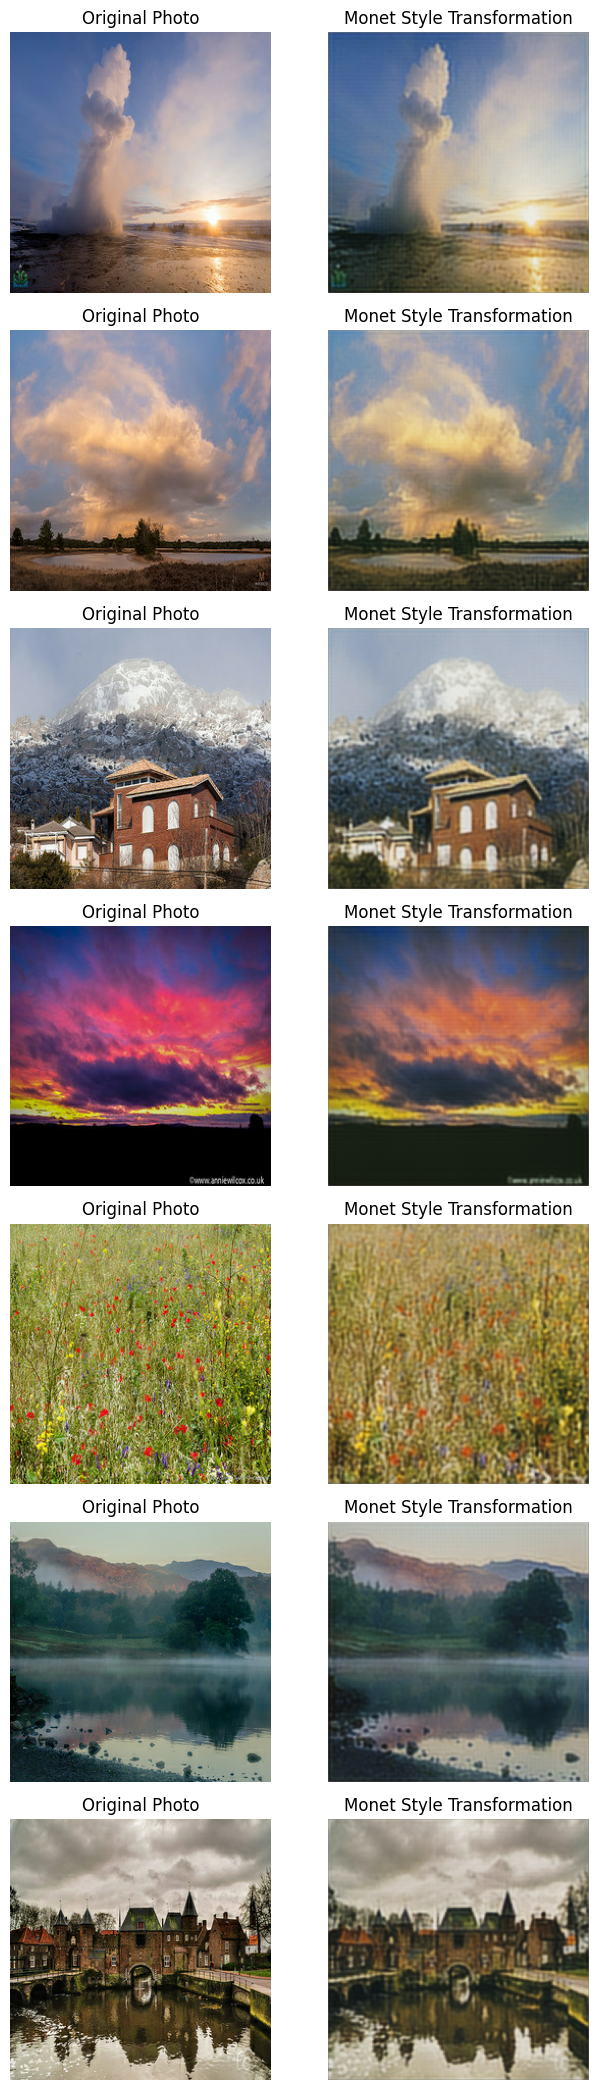

In [44]:
photo_batch = next(iter(photo_dataset))
indices = [31, 6, 18, 20, 25, 28, 30]
valid_indices = [i for i in indices if i < len(photo_batch)]

visualize_transformation(photo_batch, valid_indices)
